## 1. 학습 데이터의 월 판매량과 시차 피쳐( 0,20)범위로 clip

## 2. hyper parameter 지정
- 'metric': 'rmse', # 평가지표 = rmse
- 'num_leaves': 300, # reaf node 수
- 'learning_rate': 0.005, # 디폴트0.1, 작을수록 예측성능이 높아질수있지만 과적합가능성도 올라감
- 'feature_fraction': 0.75, # 디폴트 1,개별 트리를 학습할 때 무작위로 선택되는 피쳐 비율
- 'bagging_fraction': 0.75, # 디폴트 1, 학습데이터 샘플링 비율
- 'bagging_freq': 5, # 디폴트 0, 몇번 iteration할때마다 다시 bagging을 수행할 지
- 'force_col_wise': True, # 디폴트 false, 컬럼수가 많을떄 메모리 비용을 줄일 수 있음
- 'random_state': 42 # seed 고정
- 'num_boost_round' : 1500 # 디폴트 100, 반복수행하는 횟수 
- 'early_stopping_rounds' : 150 # 디폴트 0, 검증결과가 150번동안 나아지지 않으면 멈춤
- 'categorical_feature' : ['shop_id', 'city_id', 'cat_id', 'main_cat', 'sub_cat','year','month] # 범주형 피쳐 지정
- 'verbose_eval'=100 # 몇번째마다 평가지표 출력할지

## 3. 사용 데이터
- data_4 : 월별 총 상품 평균 판매량 1/2/3개월 전 값 추가, 월 ID별 금/토/일 수 추가(보고서 내 전처리 항목 참고)

## 4. submission 여부 : NO

In [1]:
# 라이브러리 호출
import numpy as np
import pandas as pd
import time
from itertools import product 
import lightgbm

In [11]:
data = pd.read_pickle('./data/data_before_lag.pkl')
data.head()

,month_id,shop_id,item_id,cnt_month,price_mean,city_id,cat_id,main_cat,sub_cat,year,month,first_sell,sales_month,item_id_mean_cnt,sub_cat_mean_cnt,price_mean_mean_cnt,item_id/city_id_mean_cnt,shop_id/cat_id_mean_cnt
0,0,59,22154,1.0,999.0,30,37,11,1,2013,1,0,0,0.457143,0.208571,2.783668,1.0,0.096774
1,0,59,2552,0.0,0.0,30,58,13,29,2013,1,0,0,0.000000,0.046831,0.000000,0.0,0.000000
2,0,59,2554,0.0,0.0,30,58,13,29,2013,1,0,0,0.028571,0.046831,0.000000,0.0,0.000000
3,0,59,2555,0.0,0.0,30,56,13,5,2013,1,0,0,0.028571,0.060099,0.000000,0.0,0.011494
4,0,59,2564,0.0,0.0,30,59,13,40,2013,1,0,0,0.142857,0.096500,0.000000,0.0,0.013245


In [12]:
temp = data.pivot_table(index='month_id',values='cnt_month',aggfunc='mean')
temp.columns = ['mean_cnt_month']
temp.reset_index(inplace=True)
data = pd.merge(data, temp, how='left', on='month_id')
data.head()

,month_id,shop_id,item_id,cnt_month,price_mean,city_id,cat_id,main_cat,sub_cat,year,month,first_sell,sales_month,item_id_mean_cnt,sub_cat_mean_cnt,price_mean_mean_cnt,item_id/city_id_mean_cnt,shop_id/cat_id_mean_cnt,mean_cnt_month
0,0,59,22154,1.0,999.0,30,37,11,1,2013,1,0,0,0.457143,0.208571,2.783668,1.0,0.096774,0.374878
1,0,59,2552,0.0,0.0,30,58,13,29,2013,1,0,0,0.000000,0.046831,0.000000,0.0,0.000000,0.374878
2,0,59,2554,0.0,0.0,30,58,13,29,2013,1,0,0,0.028571,0.046831,0.000000,0.0,0.000000,0.374878
3,0,59,2555,0.0,0.0,30,56,13,5,2013,1,0,0,0.028571,0.060099,0.000000,0.0,0.011494,0.374878
4,0,59,2564,0.0,0.0,30,59,13,40,2013,1,0,0,0.142857,0.096500,0.000000,0.0,0.013245,0.374878


In [15]:
def make_lags(data, feature, num_lags):
    temp = data[['month_id','shop_id','item_id',feature]].copy() # 원본은 건드리지 않도록 copy()

    # lag 피쳐 생성 및 기존 데이터와 병합
    for i in range(num_lags):
        column_name = feature+'_'+str(i+1) # 새로 생성될 컬럼명 지정 
        temp.columns = ['month_id','shop_id','item_id',column_name] # temp 컬럼명 새 이름으로 재지정
        temp['month_id'] = temp['month_id']+(i+1) # month_id에 해당 lag 숫자(몇 개월 전인지)를 더하기 > 해당 숫자만큼 월이 밀린 데이터가 됨 
        data = data.merge(temp, on=['month_id','shop_id','item_id'], how='left')
        data[column_name] = data[column_name].fillna(0) # 판매이력이 없는 경우(신상품) NaN이 존재할 수 있으므로 결측치는 0으로 대체
    del temp
    return data

In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8860578 entries, 0 to 8860577
Data columns (total 19 columns):
 #   Column                    Dtype  
---  ------                    -----  
 0   month_id                  int8   
 1   shop_id                   int8   
 2   item_id                   int16  
 3   cnt_month                 float32
 4   price_mean                float32
 5   city_id                   int8   
 6   cat_id                    int8   
 7   main_cat                  int8   
 8   sub_cat                   int8   
 9   year                      int16  
 10  month                     int8   
 11  first_sell                int8   
 12  sales_month               int8   
 13  item_id_mean_cnt          float32
 14  sub_cat_mean_cnt          float32
 15  price_mean_mean_cnt       float32
 16  item_id/city_id_mean_cnt  float32
 17  shop_id/cat_id_mean_cnt   float32
 18  mean_cnt_month            float32
dtypes: float32(8), int16(2), int8(9)
memory usage: 447.9 MB


In [17]:
data = make_lags(data, 'cnt_month', 3)
data = make_lags(data, 'price_mean', 3)
data = make_lags(data, 'item_id_mean_cnt', 3)
data = make_lags(data, 'sub_cat_mean_cnt', 3)

In [18]:
data = make_lags(data, 'price_mean_mean_cnt', 3)
data = make_lags(data, 'shop_id/cat_id_mean_cnt', 3)
data = make_lags(data, 'item_id/city_id_mean_cnt', 3)
data = make_lags(data, 'mean_cnt_month', 3)

In [21]:
data.isnull().sum()

month_id                           0
shop_id                            0
item_id                            0
cnt_month                     214200
price_mean                    214200
city_id                            0
cat_id                             0
main_cat                           0
sub_cat                            0
year                               0
month                              0
first_sell                         0
sales_month                        0
item_id_mean_cnt              214200
sub_cat_mean_cnt              214200
price_mean_mean_cnt           214200
item_id/city_id_mean_cnt      214200
shop_id/cat_id_mean_cnt       214200
mean_cnt_month                214200
cnt_month_1                        0
cnt_month_2                        0
cnt_month_3                        0
price_mean_1                       0
price_mean_2                       0
price_mean_3                       0
item_id_mean_cnt_1                 0
item_id_mean_cnt_2                 0
i

In [22]:
# 테스트 데이터에 존재하지 않을 데이터 컬럼 제거
data = data.drop(['price_mean','price_mean_mean_cnt',
'item_id_mean_cnt', 'sub_cat_mean_cnt',
'price_mean_mean_cnt', 'mean_cnt_month',
'item_id/city_id_mean_cnt','shop_id/cat_id_mean_cnt'],axis=1)

In [51]:
data.isnull().sum()

month_id                           0
shop_id                            0
item_id                            0
cnt_month                     214200
city_id                            0
cat_id                             0
main_cat                           0
sub_cat                            0
year                               0
month                              0
first_sell                         0
sales_month                        0
cnt_month_1                        0
cnt_month_2                        0
cnt_month_3                        0
price_mean_1                       0
price_mean_2                       0
price_mean_3                       0
item_id_mean_cnt_1                 0
item_id_mean_cnt_2                 0
item_id_mean_cnt_3                 0
sub_cat_mean_cnt_1                 0
sub_cat_mean_cnt_2                 0
sub_cat_mean_cnt_3                 0
price_mean_mean_cnt_1              0
price_mean_mean_cnt_2              0
price_mean_mean_cnt_3              0
s

In [57]:
df_train = pd.read_csv('e:/Git_public_dodo_Riley/kaggle/Future_Sales/data/sales_train.csv')
df_train.date = df_train.date.apply(lambda x:x.replace('.','/'))
df_train.date = pd.to_datetime(df_train.date, format='%d/%m/%Y')
df_train.head()                    

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,2013-01-02,0,59,22154,999.00,1.0
1,2013-01-03,0,25,2552,899.00,1.0
2,2013-01-05,0,25,2552,899.00,-1.0
3,2013-01-06,0,25,2554,1709.05,1.0
4,2013-01-15,0,25,2555,1099.00,1.0


In [59]:
df_train = df_train[df_train.item_cnt_day<=450]
df_train = df_train[df_train.item_cnt_day>=0]
df_train.item_cnt_day.min()

1.0

In [60]:
df_train['dayofweek'] = df_train.date.dt.dayofweek
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek
0,2013-01-02,0,59,22154,999.00,1.0,2
1,2013-01-03,0,25,2552,899.00,1.0,3
3,2013-01-06,0,25,2554,1709.05,1.0,6
4,2013-01-15,0,25,2555,1099.00,1.0,1
5,2013-01-10,0,25,2564,349.00,1.0,3


In [61]:
temp = df_train.pivot_table(index='dayofweek',values='item_cnt_day',aggfunc='sum')

<AxesSubplot:xlabel='dayofweek', ylabel='item_cnt_day'>

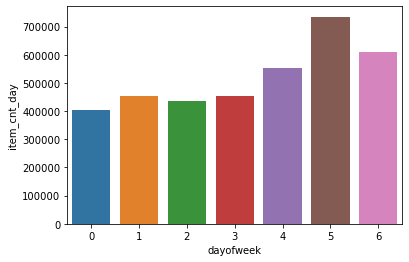

In [63]:
import seaborn as sns
sns.barplot(x=temp.index, y=temp.item_cnt_day)

In [64]:
df_train['month'] = df_train.date.dt.month
df_train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,dayofweek,month
0,2013-01-02,0,59,22154,999.00,1.0,2,1
1,2013-01-03,0,25,2552,899.00,1.0,3,1
3,2013-01-06,0,25,2554,1709.05,1.0,6,1
4,2013-01-15,0,25,2555,1099.00,1.0,1,1
5,2013-01-10,0,25,2564,349.00,1.0,3,1


In [68]:
temp2 = df_train.pivot_table(index='month', columns='dayofweek', aggfunc='size')
temp2

dayofweek,0,1,2,3,4,5,6
month,,,,,,,
1,32554,33836,38571,43779,48968,57937,46900
2,28620,28025,29329,31671,41755,60301,49770
3,31006,28220,28737,32128,43181,64655,55422
4,25108,28475,28521,27465,31990,47079,39100
5,22409,23431,29127,32721,39547,42690,34452
6,30301,29180,28795,30323,33363,43990,40961
7,29783,32878,34868,32492,32917,37923,33463
8,29913,28362,29373,33115,39045,48753,39274
9,27691,28180,25320,25131,30371,42349,40258


In [73]:
fss = pd.Series([1,3,3,4,5])
a = pd.DataFrame({'a':[1,2,3,4,5]})
a['b'] = a['a'].map(fss)
a

,a,b
0,1,3.0
1,2,3.0
2,3,4.0
3,4,5.0
4,5,NaN


In [74]:
fss = pd.Series([12,12,15,12,13,14,12,14,13,12,14,13,
                13,12,14,12,14,13,12,15,12,13,14,12,
                 14,12,13,12,15,12,13,14,12,14,13])
data['fss'] = data['month_id'].map(fss).astype(np.int8)
data.head()

,month_id,shop_id,item_id,cnt_month,city_id,cat_id,main_cat,sub_cat,year,month,...,shop_id/cat_id_mean_cnt_1,shop_id/cat_id_mean_cnt_2,shop_id/cat_id_mean_cnt_3,item_id/city_id_mean_cnt_1,item_id/city_id_mean_cnt_2,item_id/city_id_mean_cnt_3,mean_cnt_month_1,mean_cnt_month_2,mean_cnt_month_3,fss
827691,3,25,8092,3.0,13,40,11,6,2013,4,...,1.087262,1.048394,0.0,1.000000,2.142857,0.0,0.405043,0.374878,0.0,12
827692,3,25,7850,3.0,13,30,8,54,2013,4,...,3.651685,2.276650,0.0,3.714286,2.285714,0.0,0.405043,0.374878,0.0,12
827693,3,25,8051,3.0,13,66,14,47,2013,4,...,1.827586,1.389474,0.0,0.000000,0.428571,0.0,0.405043,0.374878,0.0,12
827694,3,25,8088,1.0,13,55,13,4,2013,4,...,0.598291,0.562107,0.0,0.285714,0.000000,0.0,0.405043,0.374878,0.0,12
827695,3,25,8089,1.0,13,55,13,4,2013,4,...,0.598291,0.562107,0.0,0.571429,0.000000,0.0,0.405043,0.374878,0.0,12


In [75]:
data.isnull().sum()

month_id                           0
shop_id                            0
item_id                            0
cnt_month                     214200
city_id                            0
cat_id                             0
main_cat                           0
sub_cat                            0
year                               0
month                              0
first_sell                         0
sales_month                        0
cnt_month_1                        0
cnt_month_2                        0
cnt_month_3                        0
price_mean_1                       0
price_mean_2                       0
price_mean_3                       0
item_id_mean_cnt_1                 0
item_id_mean_cnt_2                 0
item_id_mean_cnt_3                 0
sub_cat_mean_cnt_1                 0
sub_cat_mean_cnt_2                 0
sub_cat_mean_cnt_3                 0
price_mean_mean_cnt_1              0
price_mean_mean_cnt_2              0
price_mean_mean_cnt_3              0
s

In [76]:
data_1 = data.drop(['first_sell','price_mean_1','price_mean_2','price_mean_3',
                    'mean_cnt_month_1','mean_cnt_month_2','mean_cnt_month_3'],axis=1)

In [86]:
data_1.isnull().sum()

month_id                           0
shop_id                            0
item_id                            0
cnt_month                     214200
city_id                            0
cat_id                             0
main_cat                           0
sub_cat                            0
year                               0
month                              0
sales_month                        0
cnt_month_1                        0
cnt_month_2                        0
cnt_month_3                        0
item_id_mean_cnt_1                 0
item_id_mean_cnt_2                 0
item_id_mean_cnt_3                 0
sub_cat_mean_cnt_1                 0
sub_cat_mean_cnt_2                 0
sub_cat_mean_cnt_3                 0
price_mean_mean_cnt_1              0
price_mean_mean_cnt_2              0
price_mean_mean_cnt_3              0
shop_id/cat_id_mean_cnt_1          0
shop_id/cat_id_mean_cnt_2          0
shop_id/cat_id_mean_cnt_3          0
item_id/city_id_mean_cnt_1         0
i

In [24]:
# month_id 0,1,2 데이터 제거 > 3개월 만큼 lags 생성했기때문에 해당값이 없음
data= data.drop(data[data['month_id'] < 3].index)

In [81]:
data[['cnt_month','cnt_month_1','cnt_month_2','cnt_month_3']]=data[['cnt_month','cnt_month_1','cnt_month_2','cnt_month_3']].clip(0,20)

In [82]:
# train/validation/test data split
X_train = data_1[data_1['month_id'] < 33].drop(['cnt_month'], axis=1)
y_train = data_1[data_1['month_id'] < 33]['cnt_month']

X_valid = data_1[data_1['month_id'] == 33].drop(['cnt_month'], axis=1)
y_valid = data_1[data_1['month_id'] == 33]['cnt_month']

X_test = data_1[data_1['month_id'] == 34].drop(['cnt_month'], axis=1)

In [93]:
# hyper parameter 지정
params = {'metric': 'rmse', # 평가지표 = rmse
          'num_leaves': 300,
          'learning_rate': 0.005,
          'feature_fraction': 0.75,
          'bagging_fraction': 0.75,
          'bagging_freq': 5,
          'force_col_wise': True,
          'random_state': 42}

cat = ['shop_id', 'city_id', 'cat_id', 'main_cat', 'sub_cat','year','month']

# 데이터 셋 지정
train = lightgbm.Dataset(X_train, y_train)
valid = lightgbm.Dataset(X_valid, y_valid)
 
# 모델 훈련
start = time.time()
lgb_model = lightgbm.train(params=params,
                      train_set=train,
                      num_boost_round=1500,
                      valid_sets=(train, valid),
                      early_stopping_rounds=150,
                      categorical_feature=cat,
                      verbose_eval=100)
end = time.time()
print(f'소요시간(s) : {end-start}')

[LightGBM] [Info] Total Bins 4309
[LightGBM] [Info] Number of data points in the train set: 7596885, number of used features: 29
[LightGBM] [Info] Start training from score 0.306474
Training until validation scores don't improve for 150 rounds
[100]	training's rmse: 1.01776	valid_1's rmse: 0.913936
[200]	training's rmse: 0.912798	valid_1's rmse: 0.844188
[300]	training's rmse: 0.858989	valid_1's rmse: 0.818369
[400]	training's rmse: 0.829315	valid_1's rmse: 0.808834
[500]	training's rmse: 0.810984	valid_1's rmse: 0.805474
[600]	training's rmse: 0.796848	valid_1's rmse: 0.804517
[700]	training's rmse: 0.785931	valid_1's rmse: 0.805188
Early stopping, best iteration is:
[615]	training's rmse: 0.795103	valid_1's rmse: 0.80429
소요시간(s) : 454.872802734375
